# Lane Finding Project

This notebook implements the pipeline to find and draw lanes on image and video feed from a camera car. It can be divided divided in 3 sections:

1. A general libraries' import and definition of helper functions
2. The application of the proposed pipeline on one image first and then a set of examples
3. The application of the pipeline to two different examples of video feeds

## General Imports and Helper Functions

### Import Packages

Import libraries for plotting, image manipulation, computer vision 

In [8]:
# Importing some useful packages

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

### Helper Functions

These functions were provided as part of the original material - the draw_lines one has been modified and extended to allow annotation of continuous lines  

In [9]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    Function that averages angular coefficicent and parameter for right and left lane and 
    then plots them as continuous segments.
    For each of the already identified segments an angular coefficient and a parameter are
    calculated (so to write the equation in the form y = m*x +n), and then averaged on the
    set of segments constituting the left and right lane. A continuous line is then drawn 
    using the average values.
    
    The lanes are distinguished through the angular coefficient (<0 for left lane, >0 for right lanes)
    Also, some simple filtering is provided in the averaging, to avoid eventual residual outliers
    """
    # Initial values
    m_l = 0 # Left lane angular coefficient
    m_r = 0 # Right lane angular coefficient
    b_l = 0 # Left lane parameter 
    b_r = 0 # Right lane parameter

    # Counters
    ll_count = 0 # Num. of left lanes segments
    rl_count = 0 # Num. of right lane segments
    diff = 0     # This variable is going to calculate the delta between the current m and the average so far
                 # the idea is to use it to filter out eventual outliers
    
    # This is going to be the "top" y coordinate for every line 
    #   In this implementation, it shares the same value used to defined a triangular "mask" on the image later on.
    #   More sophisticated choices could make this an adaptive paramer, or extract it from the analysed segments.
    
    top_y = int(round(6*imshape[0]/10))

    for line in lines:
        for x1,y1,x2,y2 in line:
            m = (y2-y1)/(x2-x1)
            b = y1-(x1*m)
            
            if (m<0):
                if (m_l!=0):
                    diff = abs((m-m_l)/m_l)
                
                if (diff<0.2): # Value considered only if the delta between current m and average is < 20%
                    # Count and calc averages
                    ll_count = ll_count+1
                    m_l = ((m_l*(ll_count-1))+m)/ll_count
                    b_l = ((b_l*(ll_count-1))+b)/ll_count
                
            if (m>0):
                if (m_r!=0):
                    diff = abs((m-m_r)/m_r)
                    
                if (diff<0.2): # Value considered only if the delta between current m and average is < 20%
                    # Count and calc averages
                    rl_count = rl_count+1
                    m_r = ((m_r*(rl_count-1))+m)/rl_count
                    b_r = ((b_r*(rl_count-1))+b)/rl_count
                
    # Define the segments
    leftmost_x1 = int(round((top_y-b_l)/m_l))
    leftmost_y1 = top_y

    leftmost_x2 = int(round((img.shape[1]-b_l)/m_l))
    leftmost_y2 = img.shape[1]
    
    rightmost_x1 = int(round((top_y-b_r)/m_r))
    rightmost_y1 = top_y
    
    righmost_x2 = int(round((img.shape[1]-b_r)/m_r))
    rightmost_y2 = img.shape[1]
    
    # Draw the segments
    cv2.line(img, (leftmost_x1, leftmost_y1), (leftmost_x2, leftmost_y2), color, thickness)
    cv2.line(img, (rightmost_x1, rightmost_y1), (righmost_x2, rightmost_y2), color, thickness)


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

### Process one image at the time

This functions fundamentally represents the as described and documented in the writeup. Note that step 6 and 7 are actually commented out because, even if helpful from a troubleshooting perspective, do not affect the final image.

In [10]:
def process_one_image(image_in, kernel_size, low_can_t, high_can_t, vertices, rho, theta, threshold, min_line_len, max_line_gap):
    # 1. Convert the image in gray scale
    gray=grayscale(image_in)
    
    # 2. Apply gaussian blur
    blur_gray = gaussian_blur(gray, kernel_size)
    
    # 3. Canny edge detection
    edges = canny(blur_gray, low_can_t, high_can_t)
    
    # 4. Mask the edges
    masked_edges = region_of_interest(edges, vertices)
    
    # 5. Apply Hough Transform
    line_image = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)

    # 6. Create a "color" binary image to combine with line image
    #  - This step is reported here for completeness and does not actually affect the final image
    # color_edges = np.dstack((masked_edges, masked_edges, masked_edges))

    # 7. Draw the lines on the edge image
    #  - This step is reported here for completeness and does not actually affect the final image
    # lines_edges = weighted_img(line_image, color_edges, α=0.8, β=1., γ=0.)
    
    # 8. Define final image
    final_img = weighted_img(line_image, image_in, α=0.8, β=1., γ=0.)
    
    return final_img

## Implementation on Images

Here the pipeline is implemented on one image first and then a set of them

### Define Common Parameters

We group here parameters to be used by the various functions in the pipeline

In [11]:
# Define a kernel size for Gaussian smoothing / blurring
kernel_size = 5 

# Define parameters for Canny 
low_threshold = 50
high_threshold = 150

# Define the Hough transform parameters
rho = 1             # distance resolution in pixels of the Hough grid
theta = np.pi/180   # angular resolution in radians of the Hough grid
h_threshold = 20    # minimum number of votes (intersections in Hough grid cell)
min_line_len = 10   # minimum number of pixels making up a line
max_line_gap = 1    # maximum gap in pixels between connectable line segments

### Read in an Image

Here and in the following two cells we read, process and save a single image.

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


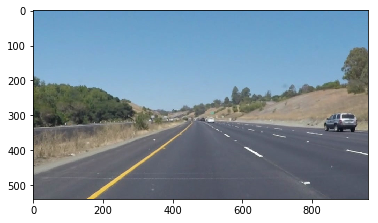

In [12]:
in_image = mpimg.imread('test_images/solidYellowCurve.jpg')

# Printing out some stats and plotting
print('This image is:', type(in_image), 'with dimensions:', in_image.shape)
plt.imshow(in_image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

### Process an image

In [13]:
# Define a triangular area of interest based on the size of the image
imshape = in_image.shape
vertices = np.array([[(0,imshape[0]),(imshape[1]/2, 6*imshape[0]/10), (imshape[1],imshape[0])]], dtype=np.int32)

# Process the image
out_image = process_one_image(in_image, kernel_size, low_threshold, high_threshold, vertices, rho, theta, h_threshold, min_line_len, max_line_gap)


### Save and Display the Image

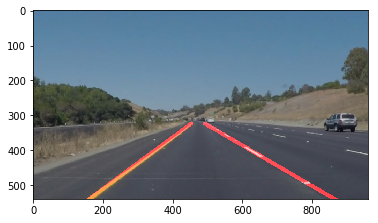

In [14]:
# Save in fixed name and location
mpimg.imsave("test_images_out/test_process.jpg",out_image)

# Display
plt.imshow(out_image)

### Running the test on the full set of images

Once the pipeline has been proven on a single image we can process and analyze (off-line in this case) the set of images provided as examples

In [8]:
import os
images_list = os.listdir("test_images/")

# Iterate over images 
for item in images_list:
    im = mpimg.imread("test_images/" + item)
    
    # Process the image
    out_im = process_one_image(im, kernel_size, low_threshold, high_threshold, vertices, rho, theta, h_threshold, min_line_len, max_line_gap)

    # Save images
    mpimg.imsave("test_images_out/processed_" + item ,out_im)


## Test on Videos

After verifying images we can move to videos.

### General Import

In [15]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

### Create simpler pipeline function

The previous pipeline is here further simplified in format to make it usable by the video management libraries

In [16]:
def process_image(image):
    
    # Define a triangular area of interest
    imshape = image.shape
    vertices = np.array([[(0,imshape[0]),(imshape[1]/2, 6*imshape[0]/10), (imshape[1],imshape[0])]], dtype=np.int32)

    # Process the image
    result = process_one_image(image, kernel_size, low_threshold, high_threshold, vertices, rho, theta, h_threshold, min_line_len, max_line_gap)

    return result

### White right lane

First video feed example

In [17]:
# Define Output
white_output = 'test_videos_output/processed_ solidWhiteRight.mp4'

# Read Input
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")

# Process video
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/processed_ solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/processed_ solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:02<00:00, 93.84it/s] 


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/processed_ solidWhiteRight.mp4 

CPU times: user 2.57 s, sys: 490 ms, total: 3.06 s
Wall time: 2.65 s


In [18]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

### Left Yellow Lane

Second video feed example

In [13]:
# Define Output
yellow_output = 'test_videos_output/processed_solidYellowLeft.mp4'

# Read Input
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')

# Process Video
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/processed_solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/processed_solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:09<00:00, 75.02it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/processed_solidYellowLeft.mp4 

CPU times: user 6.93 s, sys: 1.58 s, total: 8.51 s
Wall time: 9.51 s


In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))